### Določanje nivoja proženja

In [7]:
#common libraries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
plt.rcParams['figure.dpi'] = 1000
import numpy as np
import os
from IPython import get_ipython
import pandas as pd
import statistics
from importlib import reload

#custom libraries
import datalib as jdl
reload(jdl)


<module 'datalib' from 'c:\\Users\\Jernej Kusar\\Documents\\ŠOLA 2025-2026 1. semester\\VFSM\\Lab vaje\\poročilo_2\\datalib.py'>

In [8]:
files = jdl.getFiles_recursive(r"C:\Users\Jernej Kusar\Documents\ŠOLA 2025-2026 1. semester\VFSM\Lab vaje\poročilo_2\SK1_pon", suffix="txt")

txt_files = {}
positions = []
for f in files:
    name = int(os.path.basename(f).rstrip(".txt").split("_")[1].rstrip("mm"))
    positions.append(name)
    txt = jdl.get_data_fromTXT(f, convert_to_float=True)
    txt_files.update({name: txt})

txt_files[15] = list(np.array(txt_files[15]) - 0.2)

sorted_val = dict(sorted(txt_files.items()))
positions = sorted(positions)

In [9]:
fr = 100 #Hz
dt = 1/fr #s
time_total = 30 #s
R = 15. #mm
dx = 1
H_k = 1377. #mm
H_tot = 1486 #mm
A = np.pi * R**2


V_1 = (np.pi * R**2) * H_k
V_2 = (np.pi * R**2)*H_tot - (np.pi * R**2)*H_k

alpha_1 = V_2/(V_1 - V_2)

Ai = []
X = []
for i in positions:
    inner = max(0, i-dx/2)
    outer = min(R, i + dx/2)
    X.append(inner)
    X.append(outer)
    ai = np.pi * (outer**2 - inner**2)
    Ai.append(ai)



In [12]:
def binarise_signal(signal, threshold, high_val=1, low_val=0):
    """
    Convert a numeric signal to a binary signal based on a threshold.

    Input parameters:
        - signal [array-like]: Input numeric signal.
        - threshold [float]: Threshold value.
        - high_val [float, optional]: High bin. value
        - low_val [float, optional]: Low bin. val

    Output parameters:
        - P [array]: Binary signal (1 where signal > threshold, else 0).
    """
    signal = np.asarray(signal)

    P = np.where(signal > threshold, high_val, low_val)
    return P

def alpha_2_i(y_i, threshold, dt):
    """
    Calculates alpha from the given signal and threshold.

    Input parameters:
        - y_i [array]: signal from the phase sensor
        - threshold [float]: threshold for binarisation
        - dt [float]: time between each datapoint
    
        Output parameters:
        - alpha [float]: phase percentage
    """
    time_total = len(y_i) * dt
    y_1 = binarise_signal(y_i, threshold, dt, 0)
    time_high = sum(y_1)
    alpha = time_high/time_total

    return alpha


def alpha_2(y_all, A_i, threshold, dt):
    """
    Calulates global alpha (for the whole pipe).
    """
    upper = []
    for i,j in zip(y_all, Ai):
        alpha_i = alpha_2_i(i, threshold, dt)
        upper.append(alpha_i*j)
    
    alpha_glob = np.sum(np.array(upper))/np.sum(A_i)

    return alpha_glob

def error(threshold, alpha_1, y_all, Ai, dt):
    """
    Calculates error between alpha 1 and alpha 2 (for minimisation)

    """
    alpha2 = alpha_2(y_all, Ai, threshold, dt)

    error = np.abs(alpha_1 - alpha2)

    return float(error)



In [13]:
import numpy as np
from scipy.optimize import minimize_scalar

start = [0]
y_all = list(sorted_val.values())

# Minimize error
res = minimize_scalar(error, bounds=(0, 5), method='bounded', args=(alpha_1, y_all, Ai, dt))

p_thr = res.x
print("Optimal parameter:", res.x)
print("Minimum error:", res.fun)

Optimal parameter: 1.8152262873459561
Minimum error: 0.0016903779709257077


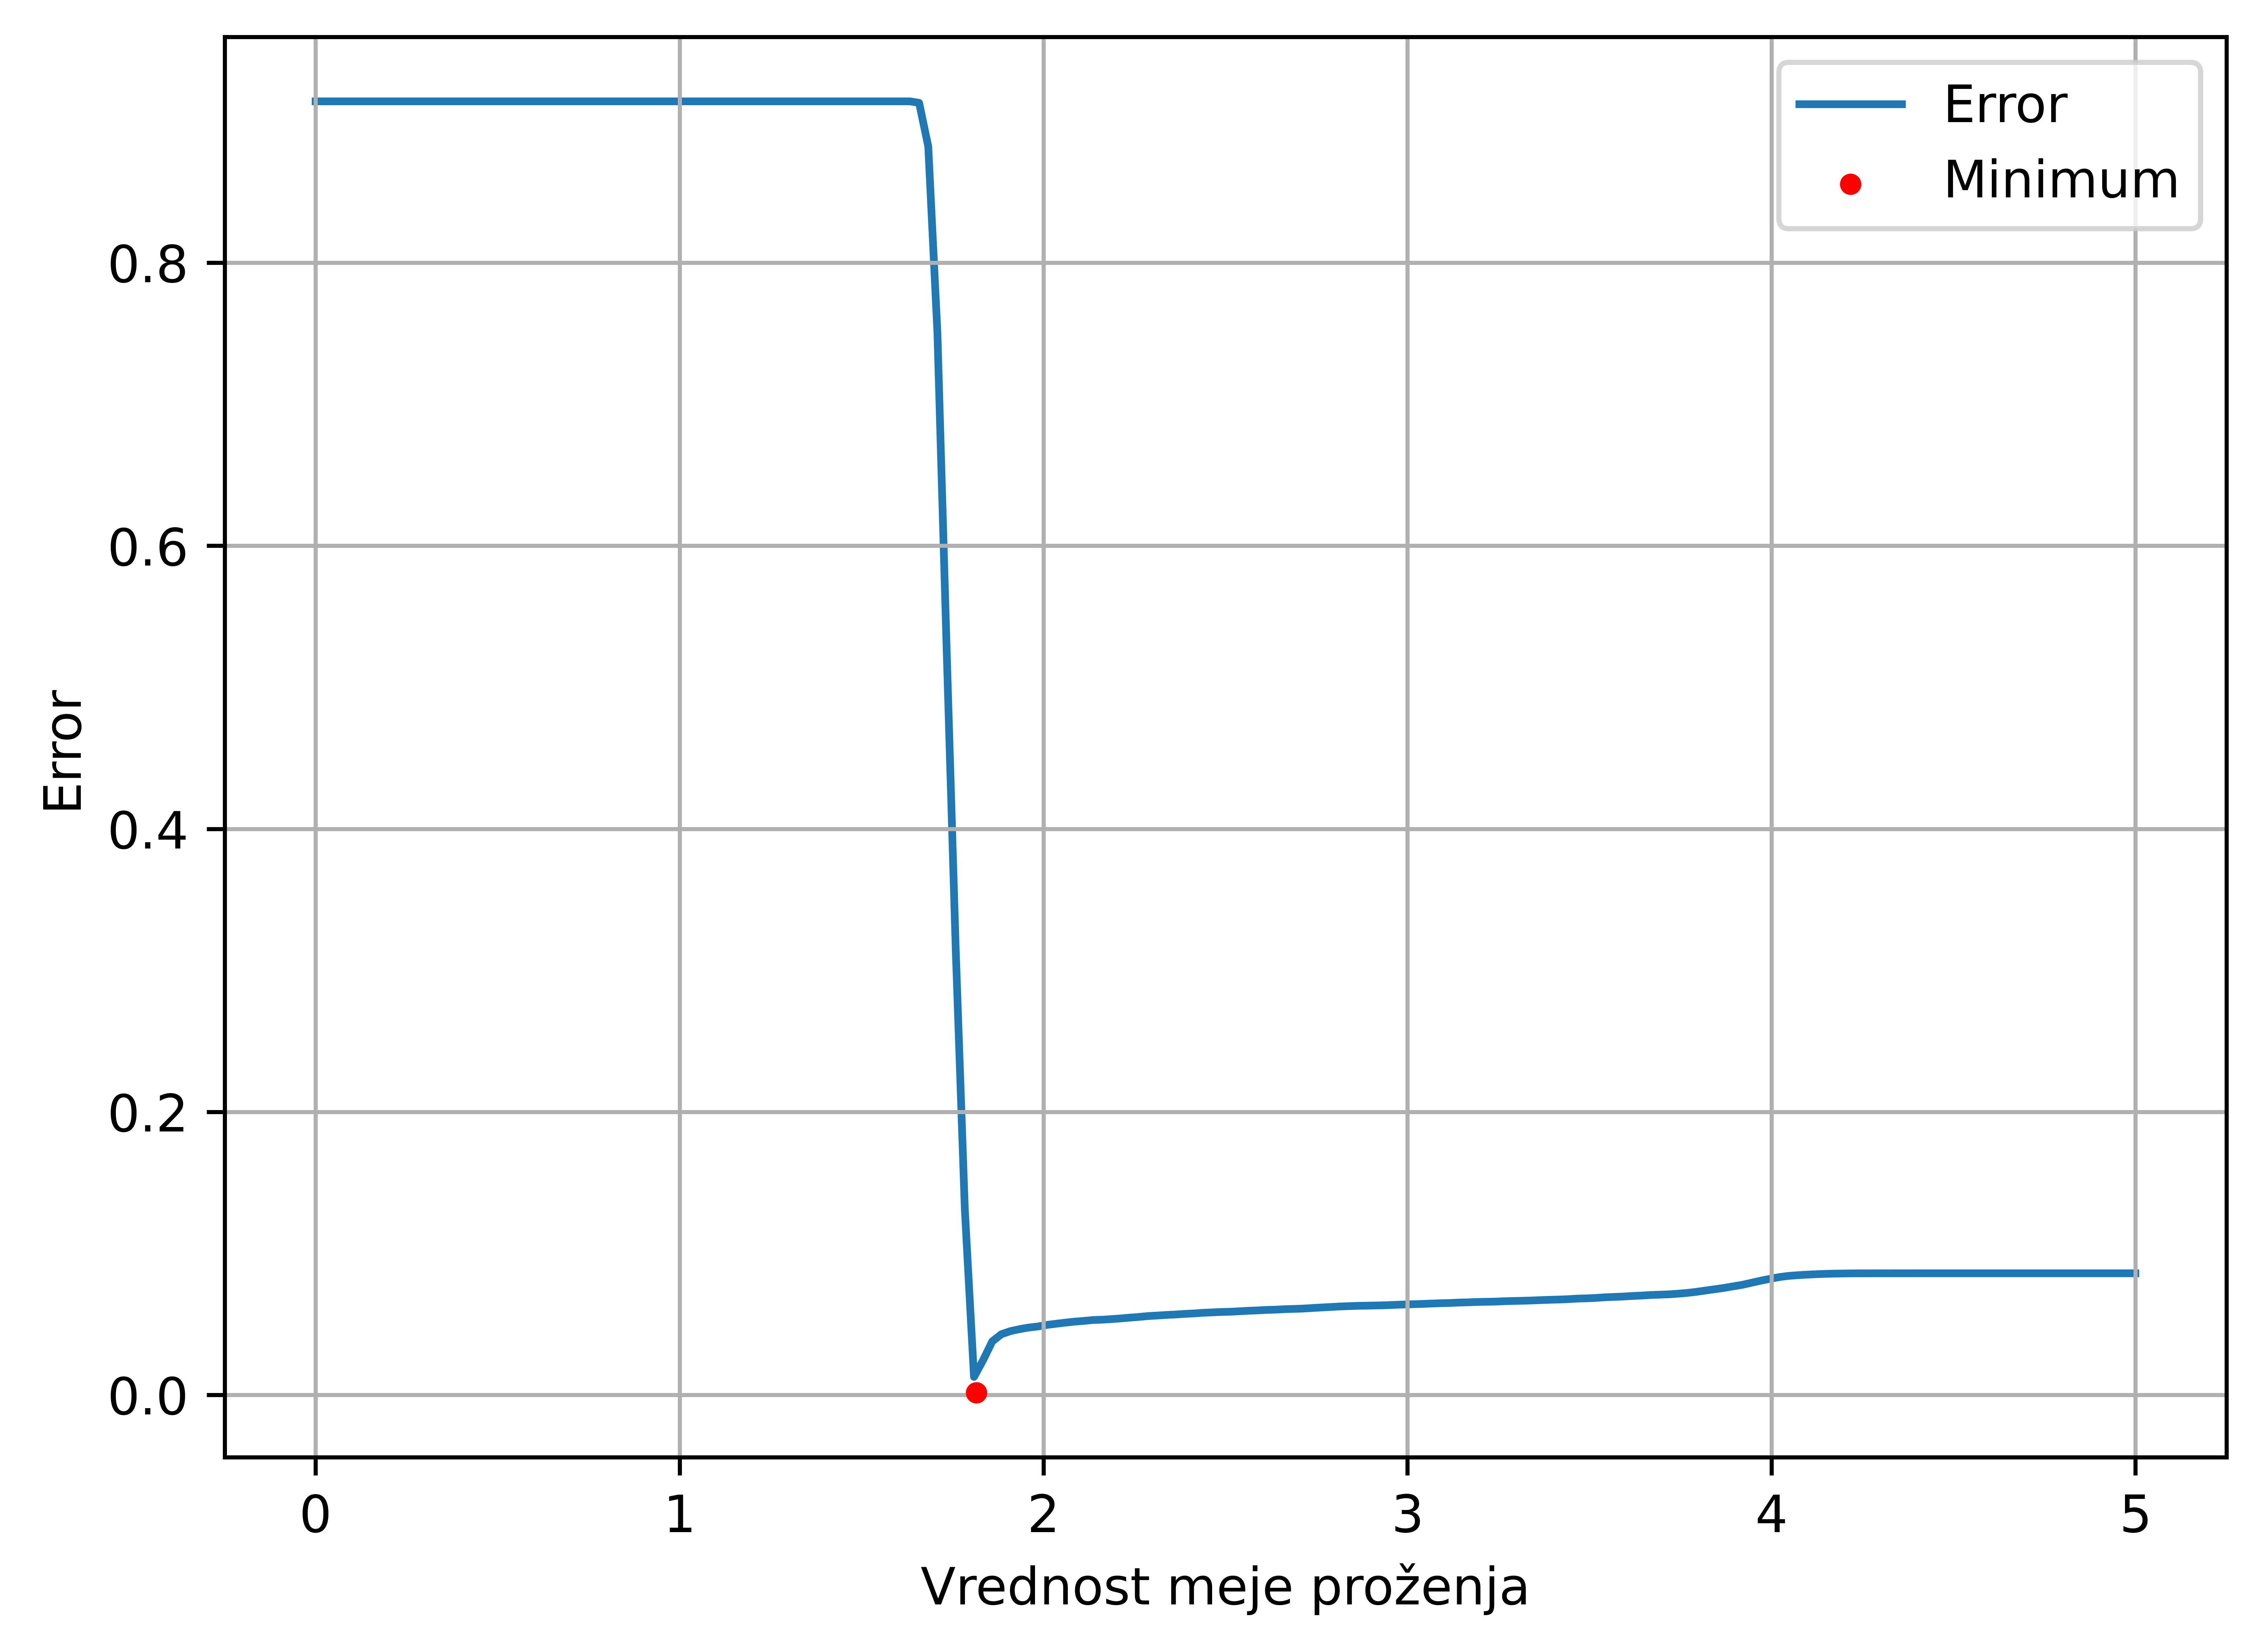

In [19]:
param_values = np.linspace(0, 5, 200)
errors = [error(p, alpha_1, y_all, Ai, dt) for p in param_values]

# Plot
plt.figure(figsize=(7,5))
plt.plot(param_values, errors, label='Error', zorder=1)
plt.scatter(res.x, res.fun, c="red", s=10, label="Minimum", zorder=2)
plt.xlabel('Vrednost meje proženja')
plt.ylabel('Error')
plt.grid(True, zorder=0)
plt.legend()
plt.show()

In [16]:
alpha_per = []
for key, val in sorted_val.items():
    a = np.mean(alpha_2_i(val, p_thr, dt))
    alpha_per.append(a)
    alpha_per.append(a)

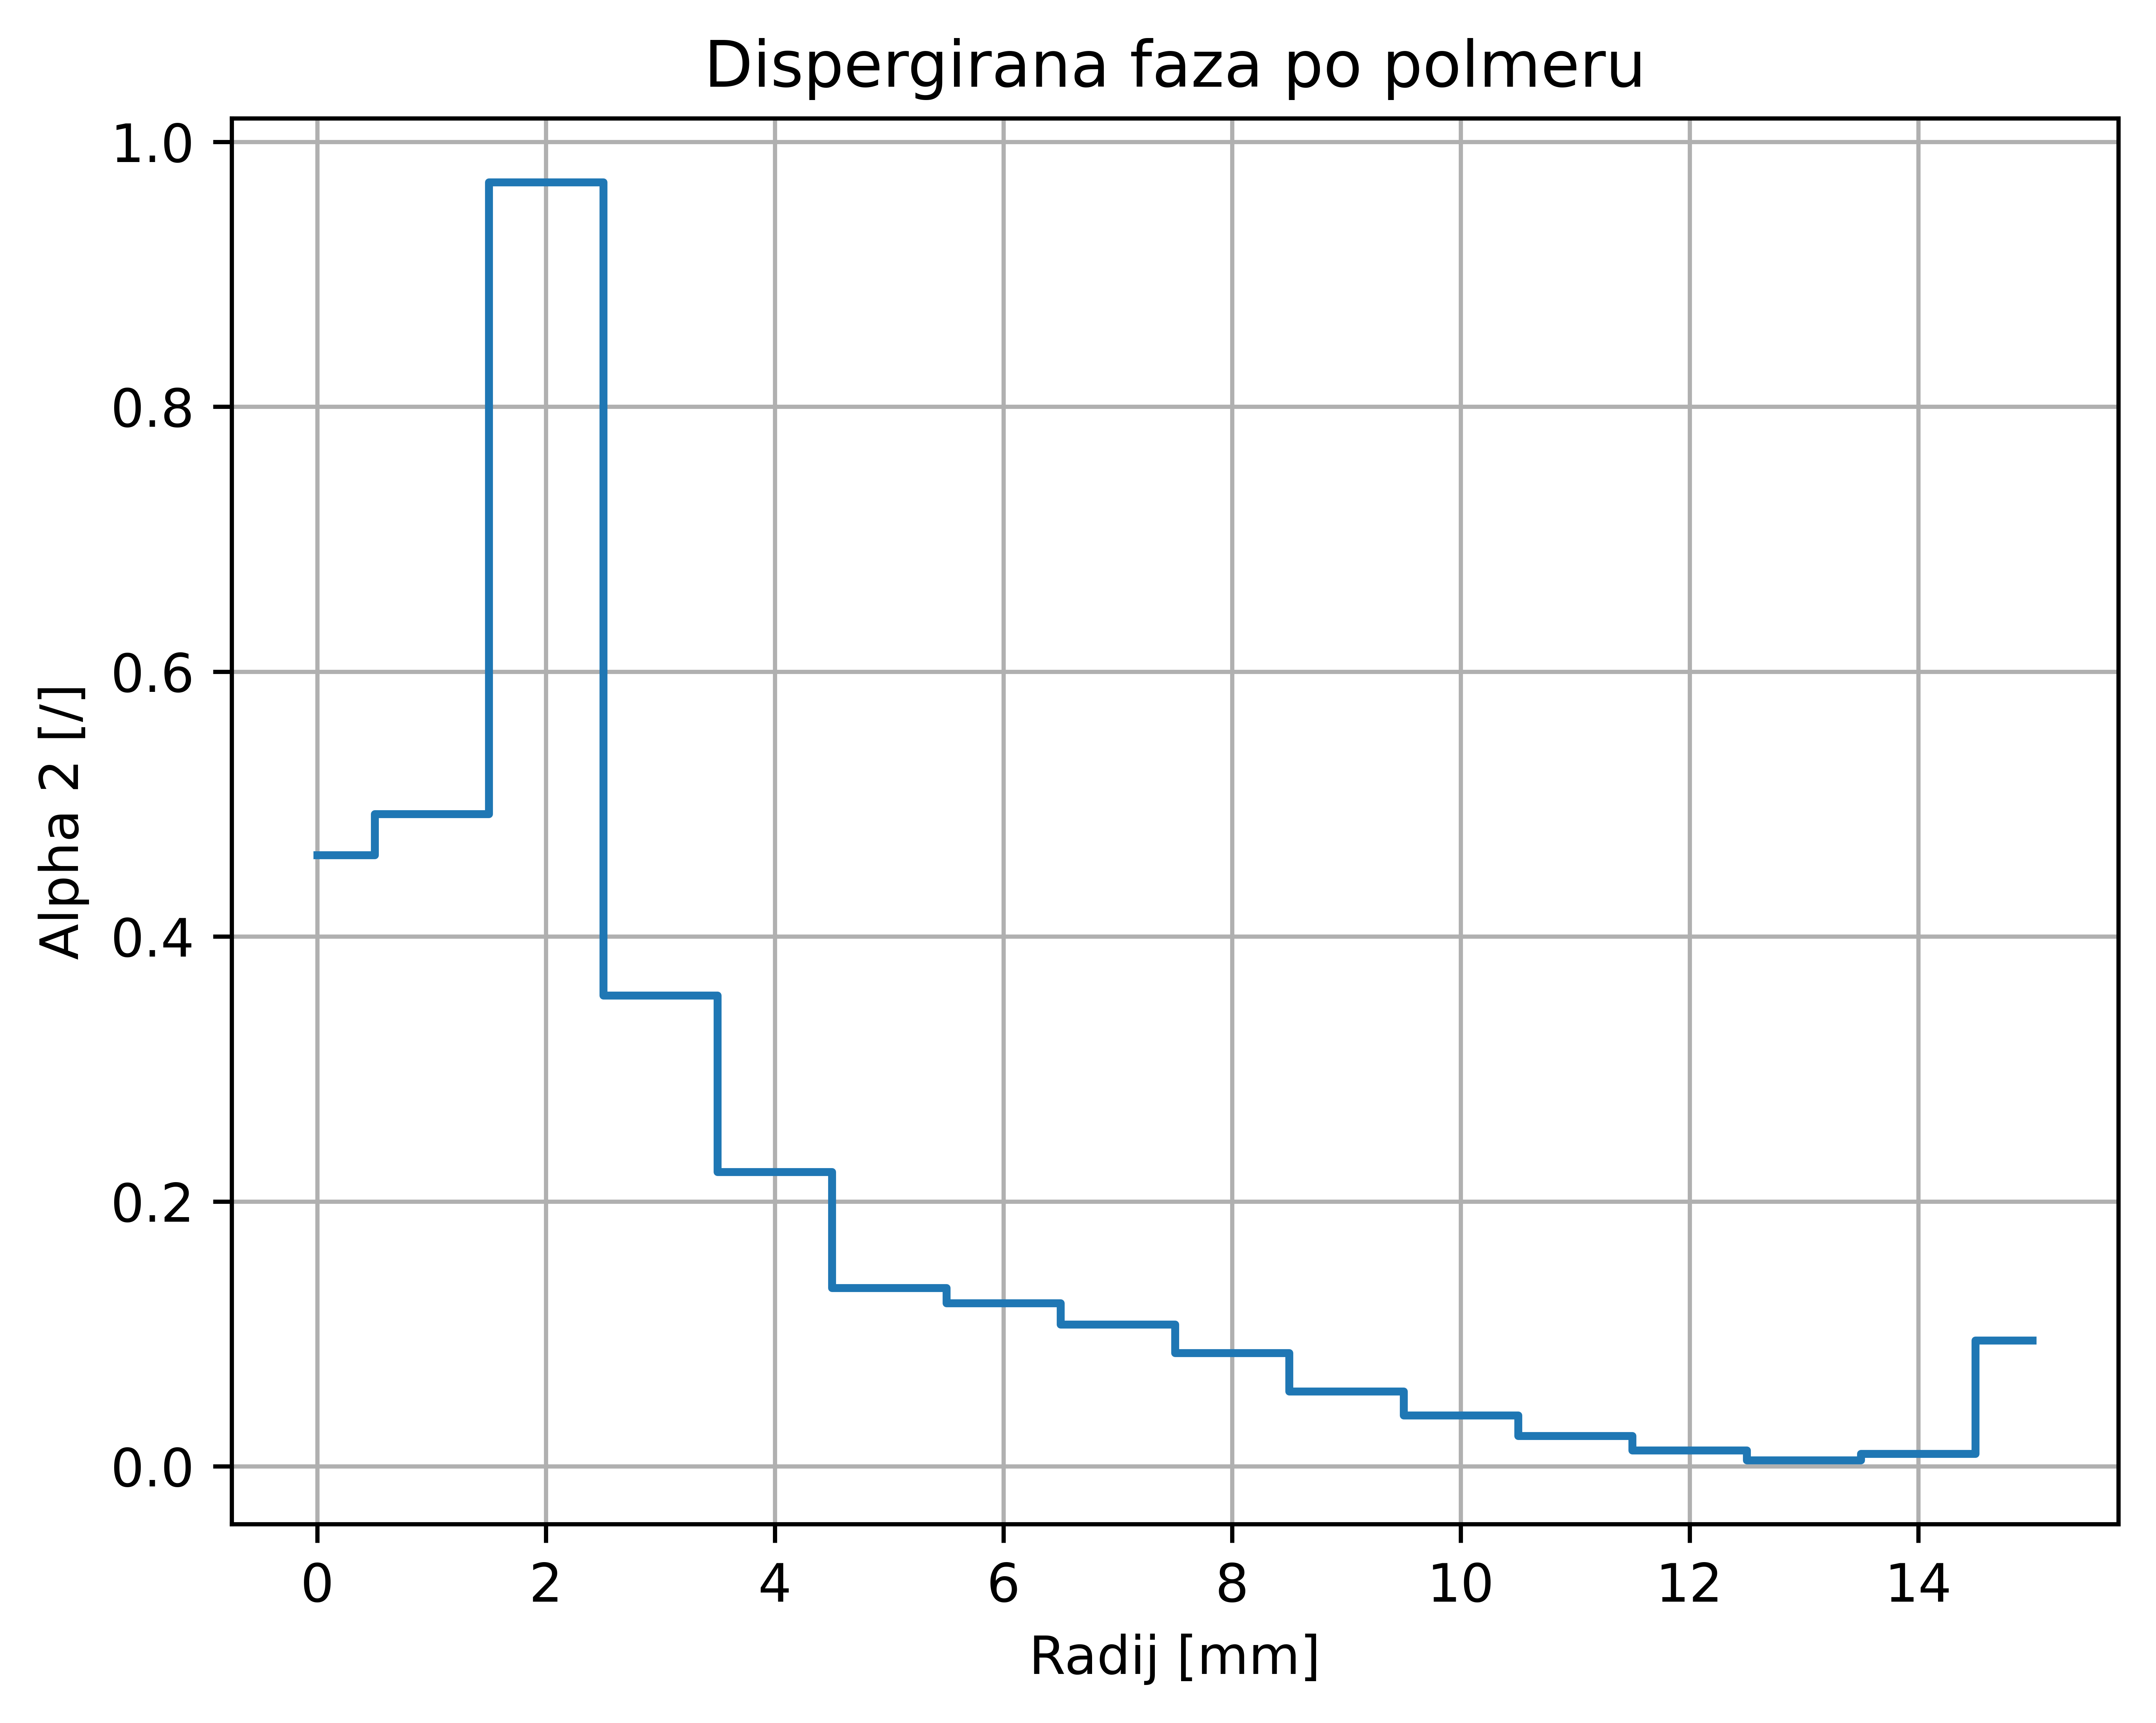

In [17]:
plt.plot(X, alpha_per)
plt.title("Dispergirana faza po polmeru")
plt.xlabel("Radij [mm]")
plt.ylabel("Alpha 2 [/]")
plt.grid()
plt.show()

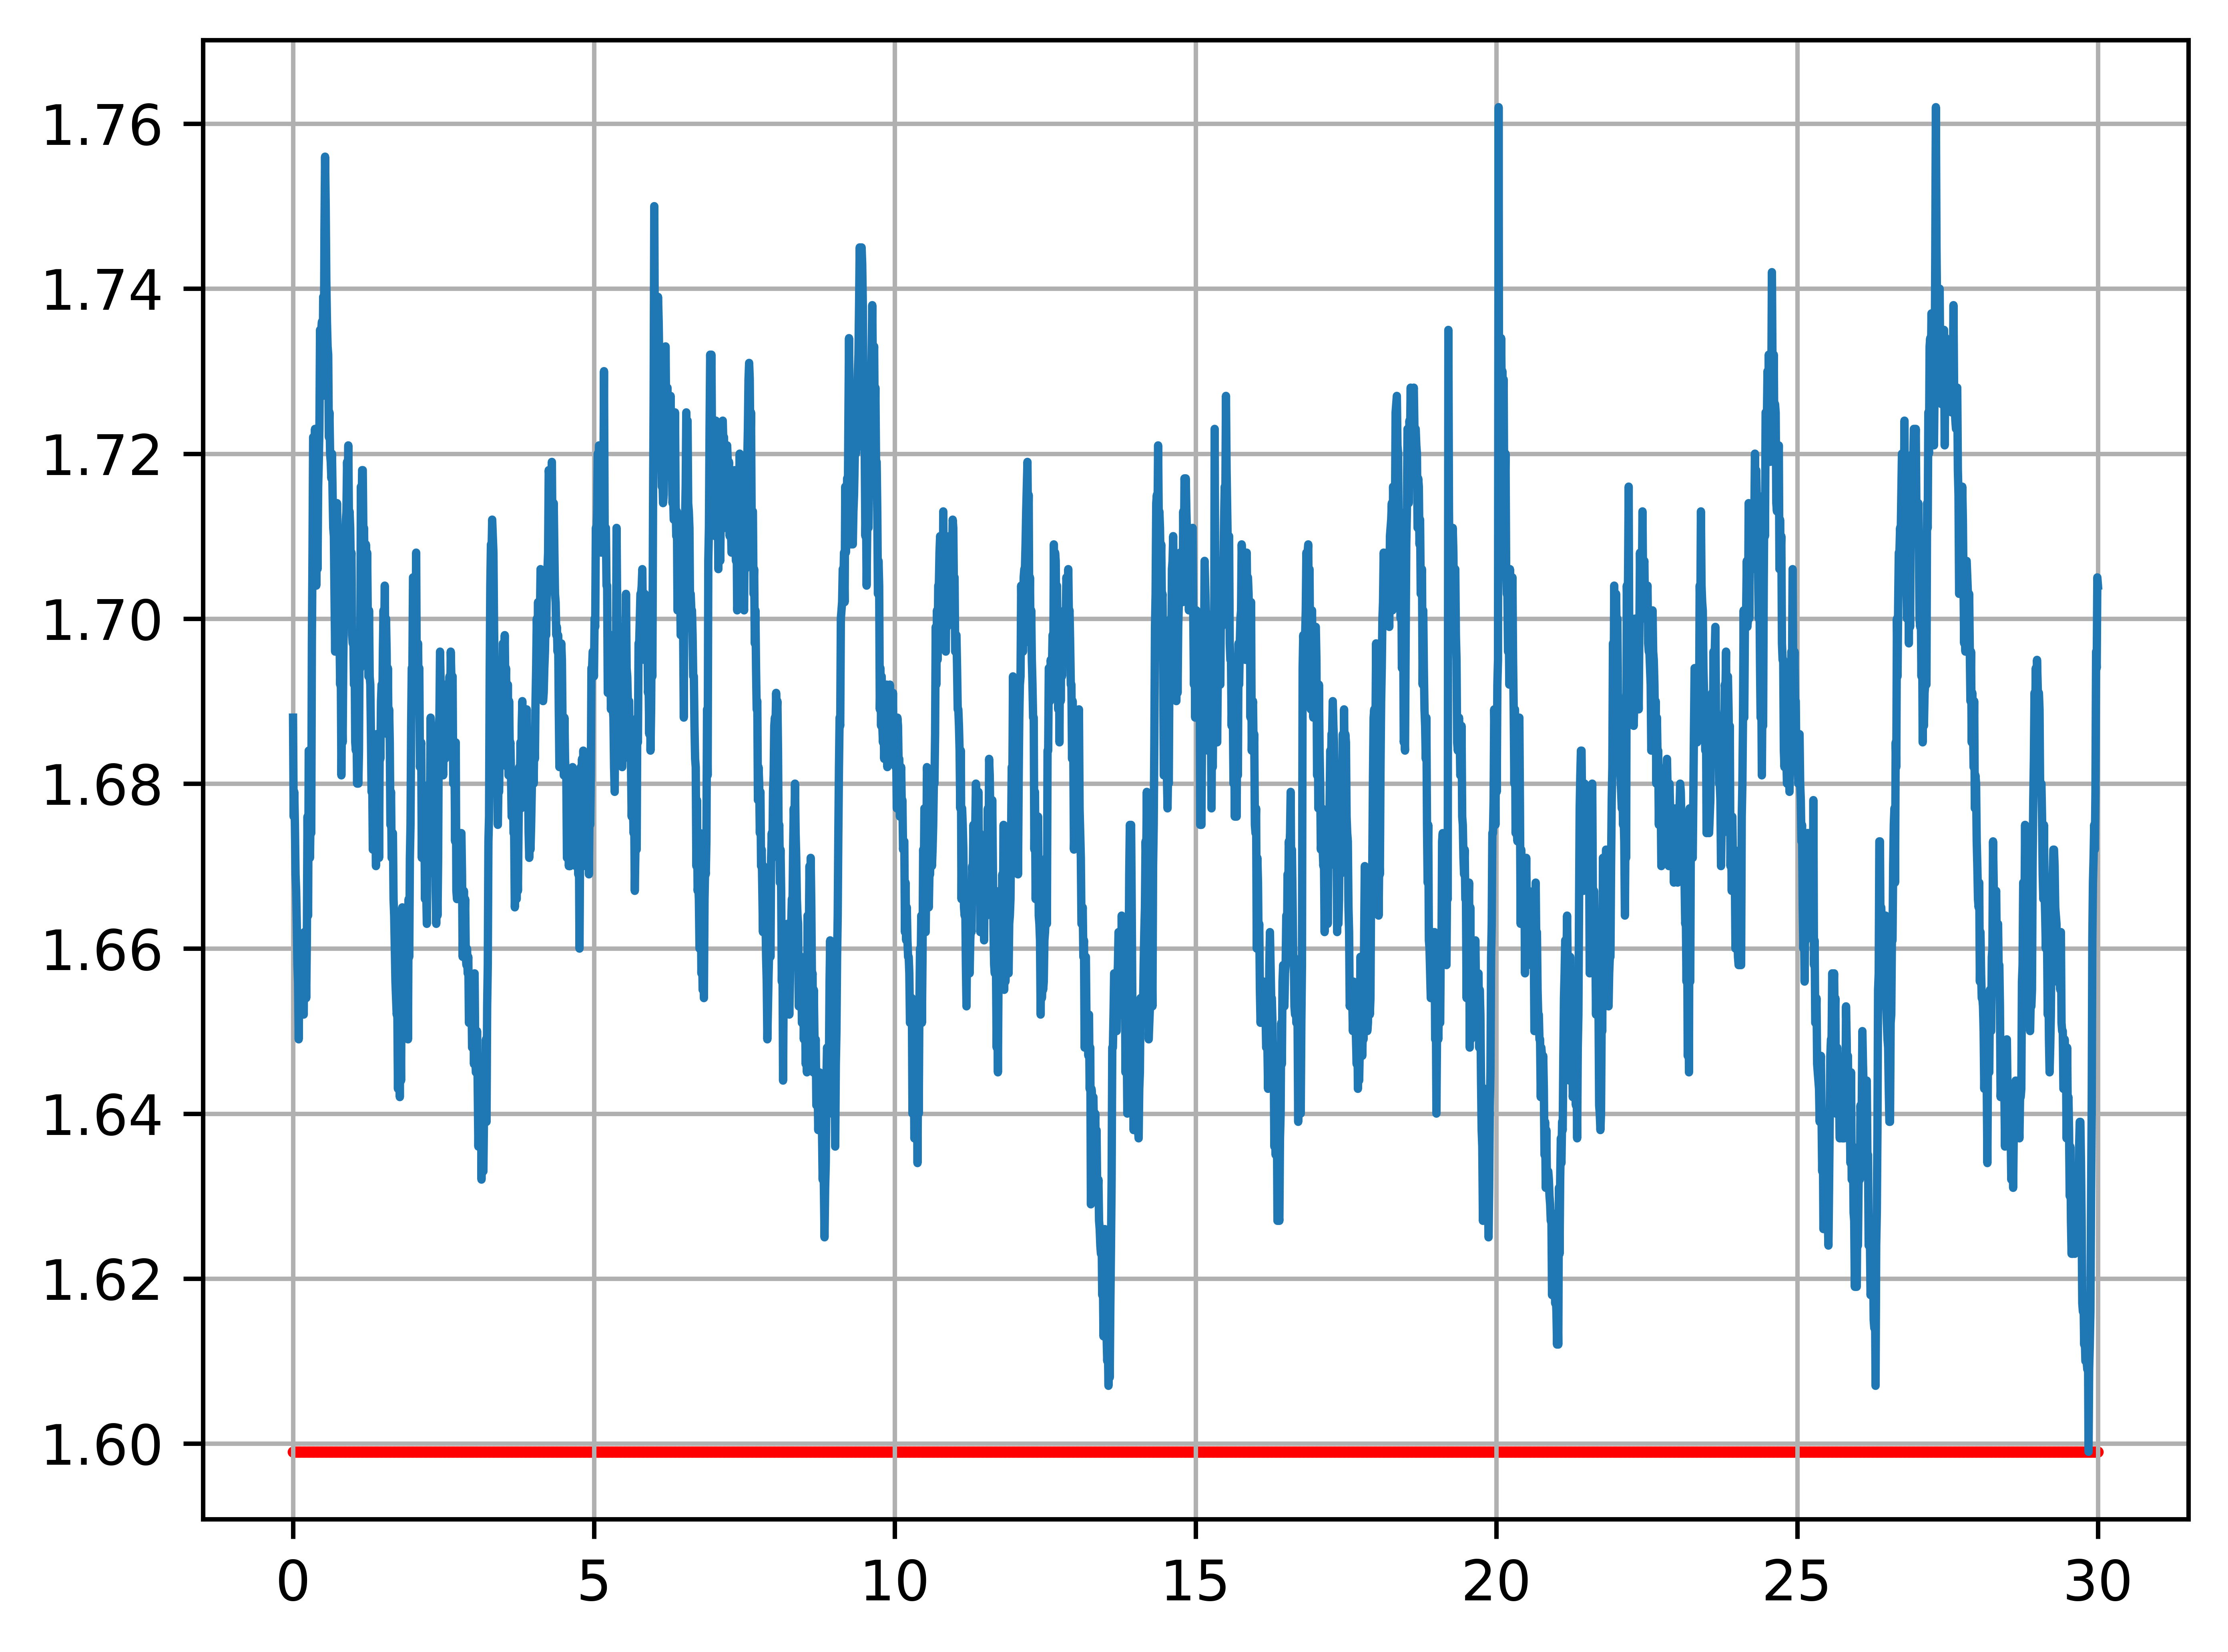

In [ ]:
y = txt_files[15]
y_1 = binarise_signal(y, p_thr, max(y), min(y))
time = np.linspace(0, time_total, len(y))

plt.scatter(time, y_1, c="red", s=1)
plt.plot(time, y)
plt.grid()